#  CNN for image classification
## Layers in CNN :  
## 1. conv1: convolution and rectified linear activation (SELU)
## 2. pool1: max pooling
## 3. Norm : Batch normalization
## 4. pool2
## 5.FC1: fully connected layer with rectified linear activation (SELU)
## 6. FC2 : fully connected layer iwth selu 
## 7. softmax layer: final output predictions i.e. classify into one of the ten classes.

In [1]:
import tensorflow as tf
import numpy as np
import _pickle as cPickle


In [2]:
"function to return x and y values from the data_batch files"

def read_data(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    X = dict[b'data'] 
    Y = np.array(dict[b'labels'])
    
    return X,Y
    

In [3]:
x_train,y_train=read_data('data_batch_2')
x_train.shape
# y_train.shape
x_test,y_test = read_data('test_batch')


## Data preprocessing : 
### Normalize X 
### One hot encode Y values {Num classes=10}

In [4]:
"Normalizing x values"
import sklearn.preprocessing as sk
x_train = sk.normalize(x_train)
x_train.shape
x_train=x_train.astype('float32')
x_train.shape
y_train=y_train.astype('float32')


In [6]:
"One ot encoding Y values"
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_train.shape
# y_train.dtype
y_test = np_utils.to_categorical(y_test, num_classes=10)


Using Theano backend.


# CNN Train pipeline  : 


In [5]:
"Function for convolution, with strides= [1,1,1,1], filter = W"

def conv2d(x_input,W):
    return tf.nn.conv2d(x_input,W,strides=[1,1,1,1],padding='SAME')

"Function for maxpool ,filter= [1,2,2,1], strides = [1,2,2,1] "

def maxpool(x_input):
    return tf.nn.max_pool(x_input,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

"Function for batch normalization"

def batch_normalization(x_input):
    return tf.nn.batch_normalization(x_input,mean=0,variance=1,offset=None,scale=1,variance_epsilon=0.0000001)

"CNN layers as given in the question"

def CNN(x_input):
    weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,3,1])),'W_fc':tf.Variable(tf.random_normal([1*8*8,3072])),
               'W_fc2':tf.Variable(tf.random_normal([3072,10])),'W_out':tf.Variable(tf.random_normal([3072,10]))}
    biases =  {'W_out':tf.Variable(tf.random_normal([10])),'W_fc2':tf.Variable(tf.random_normal([10])),'W_fc':tf.Variable(tf.random_normal([3072]))}
    x_inp=tf.reshape(x_input,shape=[-1,32,32,3])
    "1.convolution layer 1 with selu activation"
    conv1 = conv2d(x_inp,weights['W_conv1'])
    conv1_out = tf.nn.selu(conv1)
    "2. Maxpool layer"
    maxpool1 = maxpool(conv1_out)
    "3. Norm: Batch normalization"
    normalized_out = batch_normalization(maxpool1)
    "4. Maxpool2"
    maxpool2 = maxpool(normalized_out)
    "5. Fc1 -fully connected layer 1-  SELU activation"
    fc1= tf.reshape(maxpool2,[-1,8*8*1])
    fc1 = tf.nn.selu(tf.matmul(fc1,weights['W_fc'])+biases['W_fc'])
    "6. Fc2 - fully connected layer 2- Selu activation"
    fc2 = tf.reshape(fc1,[-1,3072])
    fc2 = tf.nn.selu(tf.matmul(fc2,weights['W_fc2'])+biases['W_fc2'])
    "7. Softmax layer added in train function"
    return fc2
# CNN(x_train)

In [8]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [ ]:
batch_size = 10
x= tf.placeholder(tf.float32,shape=[None,3072])
y = tf.placeholder(tf.float32, shape=(None, 10))
def train_neural_network(X,Y):
    prediction = CNN(X)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction,labels=Y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)
    tf.summary.scalar('cost', cost)
    epochs = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
#         for epoch in range(epochs):
        epoch_loss = []
        accuracy_train = []
        accuracy_test=[]
        for i in range(10):
            random_index = np.random.choice(len(X),batch_size,replace=False)
#                 
            _, loss = sess.run([optimizer,cost], feed_dict={x:X[random_index],y:Y[random_index]})
            print("Summary of epoch",i)
            print("****************************************")

            print("epoch-loss",i,loss)
            epoch_loss.append(loss)
        
            prediction1=tf.nn.softmax(prediction) """Softmax layer for the output of fc2 layer"""  
            correct_prediction = tf.to_float(tf.greater(prediction1, 0.8))
            accuracy = tf.reduce_mean(tf.to_float(tf.equal(y, correct_prediction)))
            accuracy_train.append(accuracy.eval({x:x_train, y:y_train}))
            accuracy_test.append(accuracy.eval({x:x_test, y:y_test}))
            print('train accuracy epoch',i,accuracy_train)
            print('test accuracy epoch',i,accuracy_test)
            print("****************************************")
#         print('Accuracy:Train',accuracy.eval({x:x_train, y:y_train}))
#         print('Accuracy:Test',accuracy.eval({x:x_test, y:y_test}))
    return epoch_loss, accuracy_train,accuracy_test

        


In [ ]:
epoch_loss,accuracy_train,accuracy_test=train_neural_network(x_train,y_train)

Summary of epoch 0
****************************************
epoch-loss 0 73.8129
train accuracy epoch 0 [0.82381999]
test accuracy epoch 0 [0.82362002]
****************************************
Summary of epoch 1
****************************************
epoch-loss 1 50.9576
train accuracy epoch 1 [0.82381999, 0.82765001]
test accuracy epoch 1 [0.82362002, 0.82340997]
****************************************
Summary of epoch 2
****************************************
epoch-loss 2 40.4225
train accuracy epoch 2 [0.82381999, 0.82765001, 0.82764]
test accuracy epoch 2 [0.82362002, 0.82340997, 0.82467997]
****************************************
Summary of epoch 3
****************************************
epoch-loss 3 32.459
train accuracy epoch 3 [0.82381999, 0.82765001, 0.82764, 0.83296001]
test accuracy epoch 3 [0.82362002, 0.82340997, 0.82467997, 0.83164001]
****************************************
Summary of epoch 4
****************************************
epoch-loss 4 23.7613
train accu

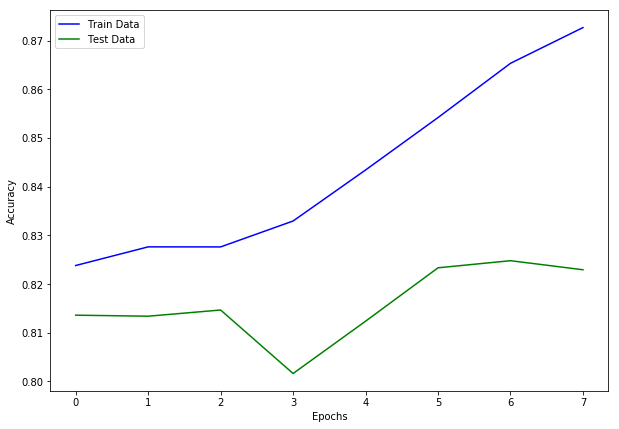

In [4]:
import matplotlib.pyplot as plt
       

accuracy_test1 = [0.81362002, 0.81340997, 0.81467997, 0.80164001, 0.81237999, 0.82334998, 0.82480999, 0.82295002]
accuracy_train1 = [0.82381999, 0.82765001, 0.82764, 0.83296001, 0.84344, 0.85421002, 0.86535001, 0.87269002]
fig = plt.figure(figsize=(10,7))
plt.plot(accuracy_train1,'b', label='Train Data')
plt.plot(accuracy_test1 ,'g', label='Test Data')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

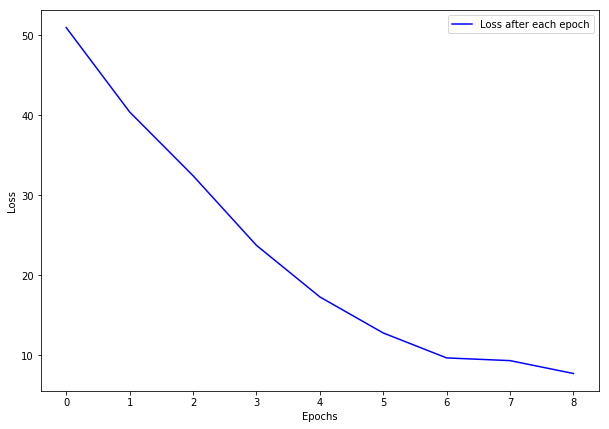

In [3]:
epoch = [50.9576,40.4225, 32.459, 23.7613,17.316, 12.811 , 9.6966, 9.35892, 7.74987]
fig = plt.figure(figsize=(10,7))
plt.plot(epoch,'b', label='Loss after each epoch')
# plt.plot(accuracy_test ,'g', label='Train Data')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
